In [1]:
import numpy as np
import pandas as pd
import polars as pl
import scipy.stats as st
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import fdrcorrection

import os
from pathlib import Path
from allensdk.core.reference_space_cache import ReferenceSpaceCache
from dynamic_routing_analysis import spike_utils
import dynamic_routing_analysis as dra

%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
#load CCF

#set this to the directory where you want the CCF to be downloaded
output_dir=dra.ANALYSIS_ROOT_PATH / "ccf_cache"
reference_space_key = 'annotation/ccf_2022'
resolution = 10
rspc = ReferenceSpaceCache(resolution, reference_space_key, manifest=Path(output_dir) / 'manifest.json')
# get structure tree
# ID 1 is the adult mouse structure graph
tree = rspc.get_structure_tree(structure_graph_id=1) 
#get id_acronym map
id_acronym_map = tree.get_id_acronym_map()
#make reference space object
rsp = rspc.get_reference_space()
#get annotation volume
annotation, meta = rspc.get_annotation_volume()

In [3]:
#load single cell metric data
# all_data_path=dra.SINGLE_UNIT_METRICS_PATH / "new_annotations/single unit metrics/combined/all_data_plus_performance.pkl"
# all_data=pd.read_pickle(all_data_path)

# all_data_loadpath=r"D:\CO single unit metrics\v272_2025-08-15\stim_context_lick_modulation.parquet"
all_data_loadpath=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO single unit metrics\v272_2025-08-15\stim_context_lick_modulation.parquet"
all_data = pd.read_parquet(all_data_loadpath)

In [4]:
session_table_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\session_table_v0.272.csv"
# session_table_path="/Users/ethan.mcbride/Data/DR/session_table_v0.265.csv"
session_table=pl.read_csv(session_table_path)

dr_session_list=(
    session_table.filter(
    pl.col('project')=="DynamicRouting",
    pl.col('is_production'),
    pl.col('is_annotated'),
    pl.col('issues')=="",
    pl.col('is_good_behavior').eq(True),
    )['session_id'].to_list()
    )

In [65]:
all_performance=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.272/consolidated/performance.parquet').collect().to_pandas()
#plot in tiers of performance
sel_project='DynamicRouting'

#get average cross modal dprime per session
session_dprime_table={
    'session_id':[],
    'cross_modality_dprime':[],
    'non_rewarded_target_response_rate':[],
    'rewarded_target_response_rate':[],
    'n_blocks_1_0':[],
    'n_blocks_1_5':[],
    'n_blocks_2_0':[],
}

for session_id in dr_session_list:
    if len(session_table.to_pandas().query('session_id==@session_id'))==0:
        continue
    if session_table.to_pandas().query('session_id==@session_id')['project'].values[0] != sel_project:
        continue
    if session_table.to_pandas().query('session_id==@session_id')['is_engaged'].values[0] == False:
        continue
    session_performance=all_performance.query('session_id==@session_id')
    session_dprime_table['session_id'].append(session_id)
    session_dprime_table['cross_modality_dprime'].append(session_performance['cross_modality_dprime'].mean())
    session_dprime_table['n_blocks_1_0'].append(session_performance.query('cross_modality_dprime>=1.0').shape[0])
    session_dprime_table['n_blocks_1_5'].append(session_performance.query('cross_modality_dprime>=1.5').shape[0])
    session_dprime_table['n_blocks_2_0'].append(session_performance.query('cross_modality_dprime>=2.0').shape[0])
    
    non_rewarded_response_rate=[]
    rewarded_response_rate=[]
    for bb,block in session_performance.iterrows():
        if block['rewarded_modality']=='vis':
            non_rewarded_response_rate.append(block['aud_target_response_rate'])
            rewarded_response_rate.append(block['vis_target_response_rate'])
        elif block['rewarded_modality']=='aud':
            non_rewarded_response_rate.append(block['vis_target_response_rate'])
            rewarded_response_rate.append(block['aud_target_response_rate'])

    session_dprime_table['non_rewarded_target_response_rate'].append(np.mean(non_rewarded_response_rate))
    session_dprime_table['rewarded_target_response_rate'].append(np.mean(rewarded_response_rate))

session_dprime_df=pd.DataFrame(session_dprime_table)
session_dprime_df

,session_id,cross_modality_dprime,non_rewarded_target_response_rate,rewarded_target_response_rate,n_blocks_1_0,n_blocks_1_5,n_blocks_2_0
0,626791_2022-08-15,1.705494,0.540387,1.000000,5,3,2
1,626791_2022-08-16,1.308840,0.612817,0.928793,5,3,1
2,636766_2023-01-23,1.965732,0.457631,0.969281,5,5,3
3,636766_2023-01-24,1.865015,0.335580,0.846991,5,4,3
4,636766_2023-01-25,1.569368,0.475404,0.913886,5,3,1
...,...,...,...,...,...,...,...
88,759434_2025-02-03,2.048774,0.183333,0.833333,5,4,4
89,759434_2025-02-04,3.096440,0.163283,1.000000,6,6,5
90,759434_2025-02-05,2.656077,0.246333,0.991228,6,6,5
91,759434_2025-02-06,2.719503,0.133333,0.950794,6,6,5


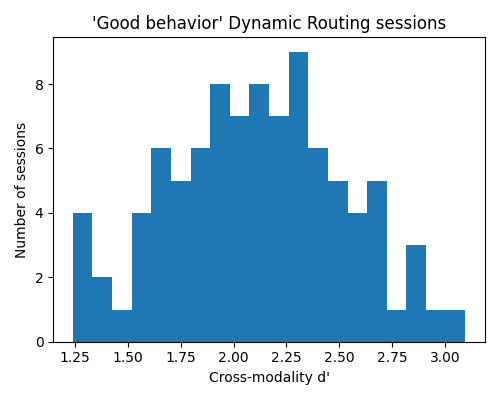

In [113]:
fig,ax=plt.subplots(figsize=(5,4))
ax.hist(session_dprime_df['cross_modality_dprime'],bins=20)
ax.set_xlabel('Cross-modality d\'')
ax.set_ylabel('Number of sessions')
ax.set_title('\'Good behavior\' Dynamic Routing sessions')
fig.tight_layout()

In [71]:
#correct pvals for multiple comparisons

sel_project='DynamicRouting'
sel_units=all_data.query('presence_ratio>=0.7 and \
                            isi_violations_ratio<=0.5 and \
                            amplitude_cutoff<=0.1 and \
                            activity_drift<=0.1 and \
                            project.str.contains(@sel_project) and \
                            ~structure.isna() and ~location.isna() and \
                            session_id in @dr_session_list')

adj_pvals=spike_utils.calculate_single_unit_metric_adjusted_pvals(sel_units,sel_project)

In [73]:
# adj_pvals.columns

In [72]:
adj_pvals=pd.merge(adj_pvals,session_dprime_df,on='session_id')

adj_pvals_shuffle=adj_pvals.copy()
#shuffle unit id, structure, location, ccf coords within each session
for session_id in adj_pvals_shuffle['session_id'].unique():
    session_mask=adj_pvals_shuffle['session_id']==session_id
    shuffled_indices=np.random.permutation(adj_pvals_shuffle[session_mask].index)
    adj_pvals_shuffle.loc[session_mask,'unit_id']=adj_pvals_shuffle.loc[shuffled_indices,'unit_id'].values
    adj_pvals_shuffle.loc[session_mask,'structure']=adj_pvals_shuffle.loc[shuffled_indices,'structure'].values
    adj_pvals_shuffle.loc[session_mask,'location']=adj_pvals_shuffle.loc[shuffled_indices,'location'].values
    adj_pvals_shuffle.loc[session_mask,'ccf_ap']=adj_pvals_shuffle.loc[shuffled_indices,'ccf_ap'].values
    adj_pvals_shuffle.loc[session_mask,'ccf_ml']=adj_pvals_shuffle.loc[shuffled_indices,'ccf_ml'].values
    adj_pvals_shuffle.loc[session_mask,'ccf_dv']=adj_pvals_shuffle.loc[shuffled_indices,'ccf_dv'].values

### plot unit metrics in selected areas - point for each unit

In [74]:
#make structure mask and collect decoder accuracy for these areas

# structure_list=['MOs','MOp','SS','ORB','FRP','ACA','ILA','PL','AI','GU','RSP','VIS','AUD','PTLp','TEa','PERI','ECT','VISC','ENT']
# structure_list=['MOs']
# structure_list=['RT']
structure_list=['CP']
# structure_list=['ORB','AI','GU','VISC','FRP']
# structure_list=['AId','AIp','AIv','GU','VISC']
# dprime_threshold=1.0

#use allensdk to get 3-d structure mask from selected areas
structure_id_list=[id_acronym_map[structure_list[0]]]
if len(structure_list)>1:
    for sel_area in structure_list[1:]:
        structure_id_list.append(id_acronym_map[sel_area])
area_mask=rsp.make_structure_mask(structure_id_list)

structure_list_join="|".join(structure_list)

#select units in these areas
area_units=sel_units.query('structure.str.contains(@structure_list_join)')
area_adj_pvals=adj_pvals.query('structure.str.contains(@structure_list_join)')
area_adj_pvals_shuffle=adj_pvals_shuffle.query('structure.str.contains(@structure_list_join)')

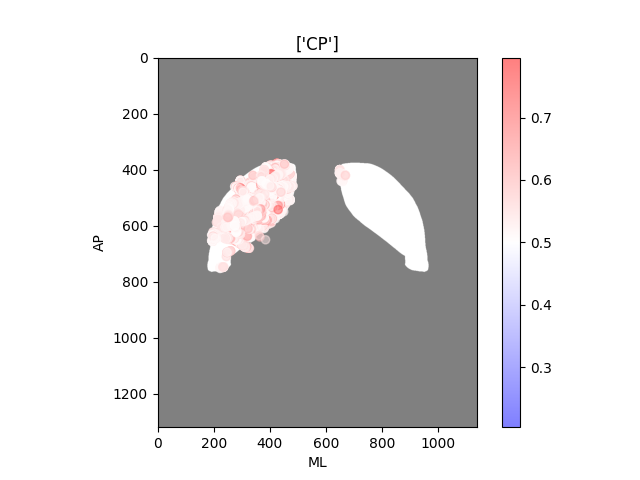

In [7]:
# plot unit metrics

### choose a metric to plot
# plot_variable='vis1_roc_auc'
# plot_variable='sound1_roc_auc'
plot_variable='context_roc_auc'
# plot_variable='lick_roc_auc'

if 'roc_auc' in plot_variable:
    #normalize roc_auc values
    plot_data=np.abs(0.5-area_adj_pvals[plot_variable].to_numpy(dtype=float))+0.5
    maxrange=np.nanmax(plot_data)*0.95
    minrange=1-maxrange
else:
    plot_data=area_adj_pvals[plot_variable].to_numpy(dtype=float)
    minrange=np.nanmin(plot_data)
    maxrange=np.nanmax(plot_data)

#horizontal view
fig,ax=plt.subplots(1,1)
ax.imshow(np.max(area_mask[:,:,:],axis=1),cmap='gray',alpha=0.5)
points=ax.scatter(area_units['ccf_ml']/10,area_units['ccf_ap']/10,c=plot_data,alpha=0.5,cmap='bwr',vmin=minrange,vmax=maxrange)
ax.set_xlabel('ML')
ax.set_ylabel('AP')
ax.set_title(structure_list)
ax.set_aspect('equal')
fig.colorbar(ax=ax,mappable=points)


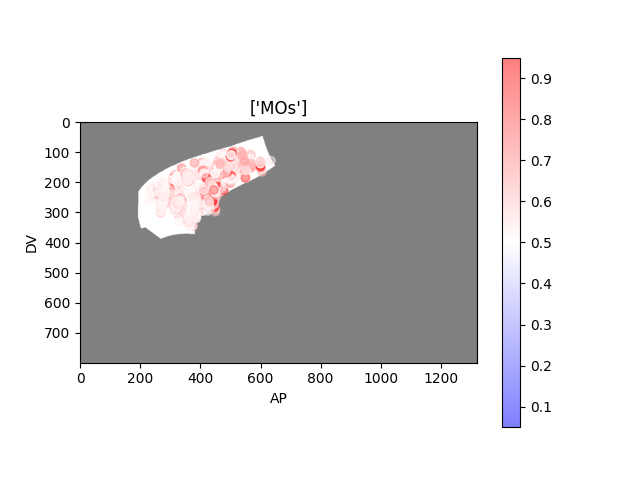

In [27]:
#sagittal view

fig,ax=plt.subplots(1,1)
ax.imshow(np.max(area_mask[:,:,:],axis=2).T,cmap='gray',alpha=0.5)
points=ax.scatter(area_units['ccf_ap']/10,area_units['ccf_dv']/10,c=plot_data,alpha=0.5,cmap='bwr',vmin=minrange,vmax=maxrange)
ax.set_xlabel('AP')
ax.set_ylabel('DV')
ax.set_title(structure_list)
ax.set_aspect('equal')
fig.colorbar(ax=ax,mappable=points)

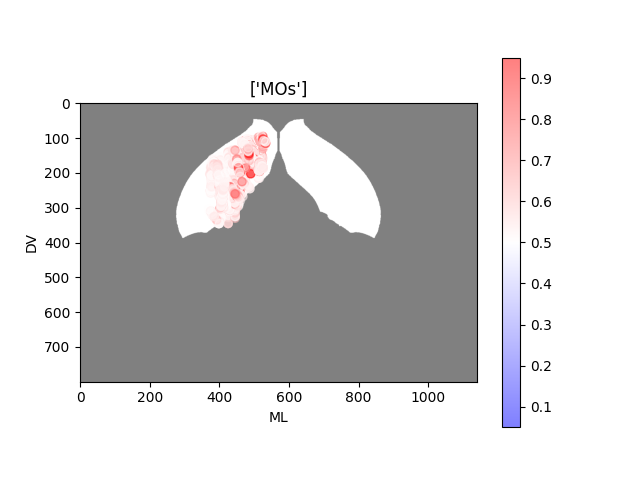

In [28]:
#coronal view

fig,ax=plt.subplots(1,1)
ax.imshow(np.max(area_mask[:,:,:],axis=0),cmap='gray',alpha=0.5)
points=ax.scatter(area_units['ccf_ml']/10,area_units['ccf_dv']/10,c=plot_data,alpha=0.5,cmap='bwr',vmin=minrange,vmax=maxrange)
ax.set_xlabel('ML')
ax.set_ylabel('DV')
ax.set_title(structure_list)
ax.set_aspect('equal')
fig.colorbar(ax=ax,mappable=points)

## 1-d histogram of unit metrics in selected areas

Text(0.5, 1.0, "['CP']")

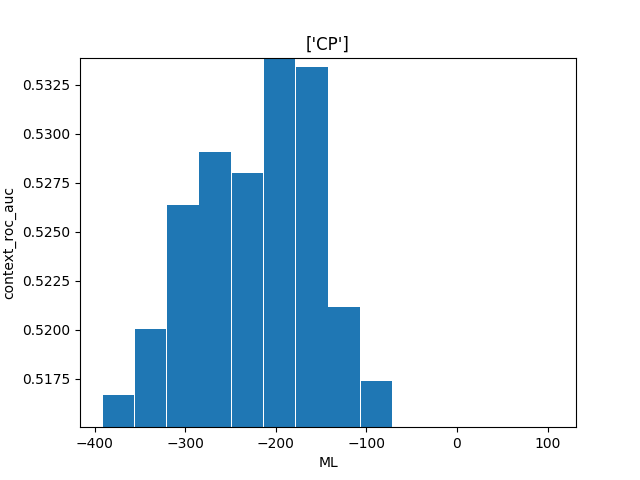

In [8]:
# medial/lateral dimension

plot_variable='context_roc_auc'

if 'roc_auc' in plot_variable:
    #normalize roc_auc values
    plot_data=np.abs(0.5-area_adj_pvals[plot_variable].to_numpy(dtype=float))+0.5
    cmap='bwr'
elif plot_variable=='n_units':
    plot_data=None
    cmap='Reds'
else:
    plot_data=area_adj_pvals[plot_variable].to_numpy(dtype=float)
    cmap='bwr'

#size of bins in microns
binsize=35

xsize=annotation.shape[2]

xinput=(area_units['ccf_ml'].to_numpy(dtype=float)/10)-(xsize/2)

# if plot_variable=='n_units':
#     statbins = st.binned_statistic(xinput, plot_data, statistic='count', bins=(int(xsize/binsize)), range=((0,xsize)))
# else:
#     statbins = st.binned_statistic(xinput, plot_data, statistic='mean', bins=(int(xsize/binsize)), range=((0,xsize)))
#     statbins_count = st.binned_statistic(xinput, plot_data, statistic='count', bins=(int(xsize/binsize)), range=((0,xsize)))

if plot_variable=='n_units':
    statbins = st.binned_statistic(xinput, plot_data, statistic='count', bins=(int(xsize/binsize)), range=((-xsize/2,xsize/2)))
else:
    statbins = st.binned_statistic(xinput, plot_data, statistic='mean', bins=(int(xsize/binsize)), range=((-xsize/2,xsize/2)))
    statbins_count = st.binned_statistic(xinput, plot_data, statistic='count', bins=(int(xsize/binsize)), range=((-xsize/2,xsize/2)))

bin_centers=(statbins.bin_edges[1:]+statbins.bin_edges[:-1])/2

fig,ax=plt.subplots(1,1)

ax.bar(bin_centers,statbins.statistic,width=binsize,align='center')
ax.set_ylim((np.nanmin(statbins.statistic),np.nanmax(statbins.statistic)))

ax.set_xlabel('ML')
ax.set_ylabel(plot_variable)
ax.set_title(structure_list)
# print(xsize)

In [77]:
area_units['ccf_ml'].to_numpy(dtype=float)/10

array([385. , 390. , 390. , ..., 495. , 510. , 497.5])

## 2-d histogram of unit metrics in selected areas

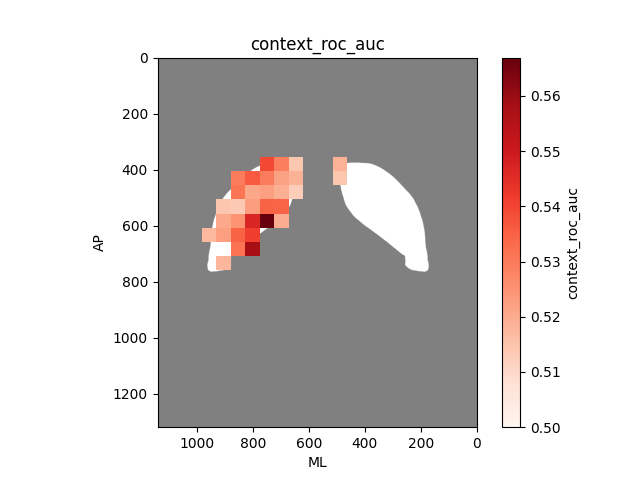

In [21]:
#horizontal view - histogram
#ccf shape = a/p, d/v, m/l

# plot_variable='sound1_roc_auc'
# plot_variable='vis1_roc_auc'
plot_variable='context_roc_auc'
# plot_variable='lick_roc_auc'
# plot_variable='n_units'
# plot_variable='vis1_context_evoked_roc_auc'

# ###need to make unit minimum work
# min_n_units=5

if 'roc_auc' in plot_variable:
    #normalize roc_auc values
    plot_data=np.abs(0.5-area_adj_pvals[plot_variable].to_numpy(dtype=float))+0.5
    cmap='bwr'
elif plot_variable=='n_units':
    plot_data=None
    cmap='Reds'
else:
    plot_data=area_adj_pvals[plot_variable].to_numpy(dtype=float)
    cmap='bwr'

#size of bins in microns
binsize=50

xsize=annotation.shape[2]
ysize=annotation.shape[0]

xinput=area_units['ccf_ml'].to_numpy(dtype=float)/10
yinput=area_units['ccf_ap'].to_numpy(dtype=float)/10

if plot_variable=='n_units':
    statbins = st.binned_statistic_2d(xinput, yinput, None, statistic='count', bins=(int(xsize/binsize), int(ysize/binsize)), range=((0,xsize), (0,ysize)))
else:
    statbins = st.binned_statistic_2d(xinput, yinput, plot_data, statistic='mean', bins=(int(xsize/binsize), int(ysize/binsize)), range=((0,xsize), (0,ysize)))
    statbins_count = st.binned_statistic_2d(xinput, yinput, None, statistic='count', bins=(int(xsize/binsize), int(ysize/binsize)), range=((0,xsize), (0,ysize)))

#require each bin to have at least 10 units
min_units_per_bin=10
valid_bins = statbins_count.statistic >= min_units_per_bin
statbins.statistic[~valid_bins] = np.nan

if 'roc_auc' in plot_variable:
    maxrange=np.nanmax(statbins.statistic)*0.99
    # minrange=1-maxrange
    minrange=0.5
    cmap='Reds'
else:
    minrange=np.nanmin(statbins.statistic)
    maxrange=np.nanmax(statbins.statistic)

fig,ax=plt.subplots(1,1)
ax.imshow(np.max(area_mask[:,:,:],axis=1),cmap='gray',alpha=0.5,aspect='equal')
values=ax.imshow(statbins.statistic.T,extent=[xsize,0,ysize,0],cmap=cmap,alpha=1,vmin=minrange,vmax=maxrange)
ax.set_aspect('equal')
ax.set_xlabel('ML')
ax.set_ylabel('AP')
# ax.set_title(structure_list)
ax.set_title(plot_variable)
fig.colorbar(ax=ax,mappable=values,label=plot_variable)

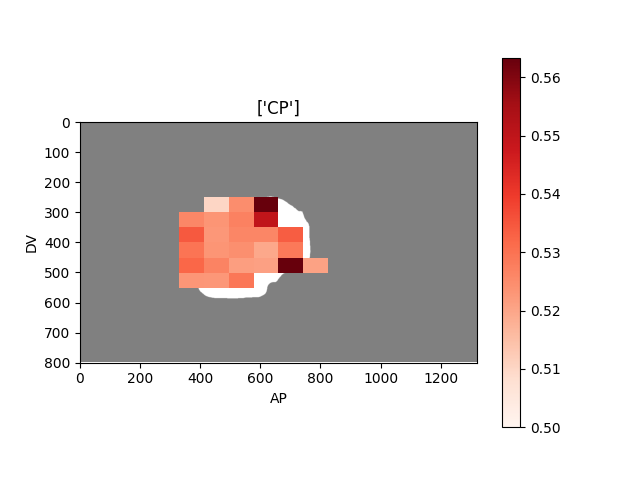

In [23]:
# sagittal view - histogram

xsize=annotation.shape[0]
ysize=annotation.shape[1]

xinput=area_units['ccf_ap'].to_numpy(dtype=float)/10
yinput=area_units['ccf_dv'].to_numpy(dtype=float)/10

statbins = st.binned_statistic_2d(xinput, yinput, plot_data, statistic='mean', bins=(int(ysize/binsize), int(annotation.shape[1]/binsize)), range=((0,xsize), (0,ysize)))
statbins_count = st.binned_statistic_2d(xinput, yinput, None, statistic='count', bins=(int(ysize/binsize), int(annotation.shape[1]/binsize)), range=((0,xsize), (0,ysize)))

#require each bin to have at least 10 units
min_units_per_bin=10
valid_bins = statbins_count.statistic >= min_units_per_bin
statbins.statistic[~valid_bins] = np.nan

if 'roc_auc' in plot_variable:
    maxrange=np.nanmax(statbins.statistic)*0.99
    # minrange=1-maxrange
    minrange=0.5
    cmap='Reds'
else:
    minrange=np.nanmin(statbins.statistic)
    maxrange=np.nanmax(statbins.statistic)

fig,ax=plt.subplots(1,1)
ax.imshow(np.max(area_mask[:,:,:],axis=2).T,cmap='gray',alpha=0.5,aspect='equal')
values=ax.imshow(statbins.statistic.T,extent=[0,xsize,ysize,0],cmap=cmap,vmin=minrange,vmax=maxrange,aspect='equal')
ax.set_aspect('equal')
ax.set_xlabel('AP')
ax.set_ylabel('DV')
ax.set_title(structure_list)
fig.colorbar(ax=ax,mappable=values)

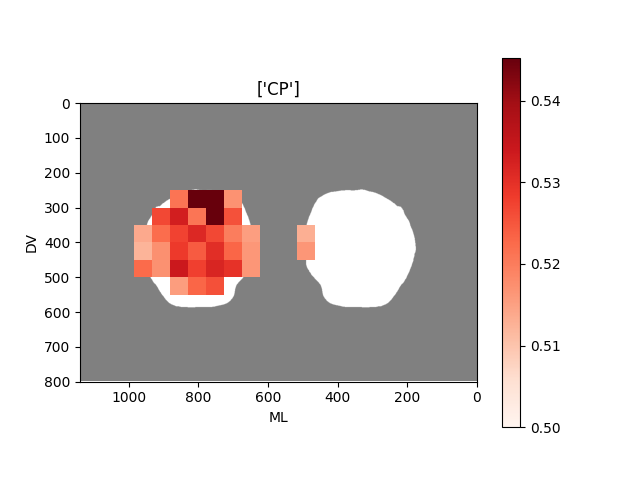

In [24]:
#coronal view - histogram

xsize=annotation.shape[2]
ysize=annotation.shape[1]

xinput=area_units['ccf_ml'].to_numpy(dtype=float)/10
yinput=area_units['ccf_dv'].to_numpy(dtype=float)/10

statbins = st.binned_statistic_2d(xinput, yinput, plot_data, statistic='mean', bins=(int(xsize/binsize), int(ysize/binsize)), range=((0,xsize), (0,ysize)))
statbins_count = st.binned_statistic_2d(xinput, yinput, None, statistic='count', bins=(int(xsize/binsize), int(ysize/binsize)), range=((0,xsize), (0,ysize)))

#require each bin to have at least 10 units
min_units_per_bin=10
valid_bins = statbins_count.statistic >= min_units_per_bin
statbins.statistic[~valid_bins] = np.nan

if 'roc_auc' in plot_variable:
    maxrange=np.nanmax(statbins.statistic)*0.99
    # minrange=1-maxrange
    minrange=0.5
    cmap='Reds'
else:
    minrange=np.nanmin(statbins.statistic)
    maxrange=np.nanmax(statbins.statistic)

fig,ax=plt.subplots(1,1)
ax.imshow(np.max(area_mask[:,:,:],axis=0),cmap='gray',alpha=0.5,aspect='equal')
values=ax.imshow(statbins.statistic.T,extent=[xsize,0,ysize,0],cmap=cmap,vmin=minrange,vmax=maxrange,aspect='equal')
ax.set_aspect('equal')
ax.set_xlabel('ML')
ax.set_ylabel('DV')
ax.set_title(structure_list)
fig.colorbar(ax=ax,mappable=values)


## plot unit metrics histogram on CCF slices - coronal

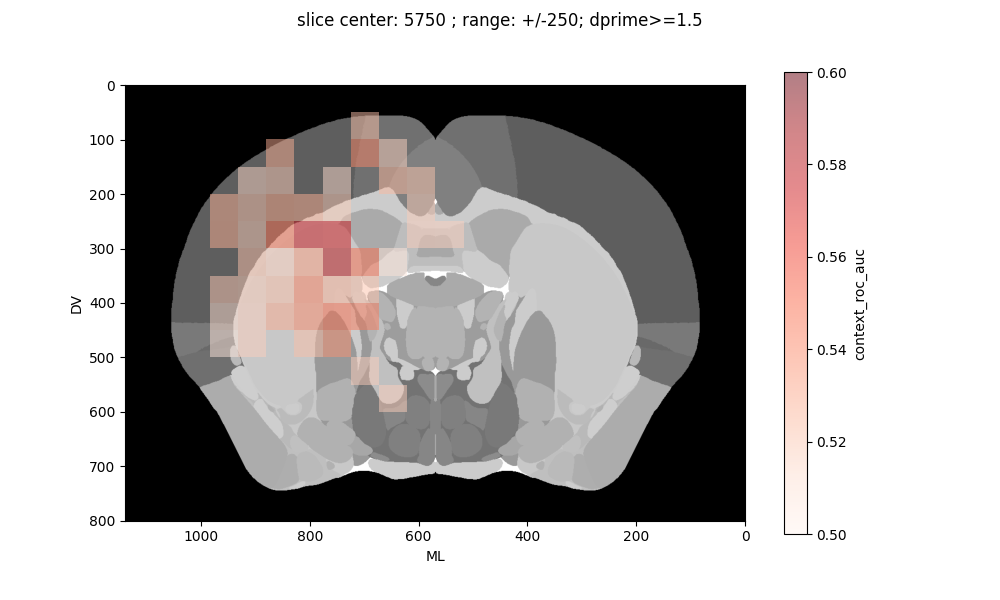

In [ ]:
# plot histogram on successive coronal slices

# plot slices
dprime_thresh=1.5

binsize=50

slice_size=500
slice_pos_array=np.arange(2000+slice_size/2,10500,slice_size)
savepath = (
    # dra.ANALYSIS_ROOT_PATH / "quick-figures/2025-08-15-single_unit_topography"
    # r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-08-15-single_unit_topography"
    r'C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-12-16_single_unit_topography'
)

plot_variable='context_roc_auc'
# plot_variable='sound1_roc_auc'
# plot_variable='vis1_roc_auc'
# plot_variable='lick_roc_auc'
# plot_variable='n_units'
# plot_variable='sound1_context_evoked_roc_auc'
# plot_variable='cross_modality_dprime'


for slice_pos in slice_pos_array[7:8]:
    slice_image= rsp.get_slice_image(0, slice_pos)
    results= adj_pvals.query('ccf_ap >= @slice_pos-@slice_size/2 and ccf_ap < @slice_pos+@slice_size/2 and cross_modality_dprime >= @dprime_thresh')

    def rgb2gray(rgb):
        return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
    
    gray_image = rgb2gray(slice_image) 

    fig = plt.figure(figsize=(10,6))
    ax=plt.subplot(1,1,1)
    # ax.imshow(data,cmap='gray',extent=[1140,0,800,0]) 
    ax.imshow(gray_image,extent=[1140,0,800,0],cmap='gray',aspect='equal') 

    xsize=annotation.shape[2]
    ysize=annotation.shape[1]

    xinput=results['ccf_ml'].to_numpy(dtype=float)/10
    yinput=results['ccf_dv'].to_numpy(dtype=float)/10

    if 'roc_auc' in plot_variable:
        plot_data=np.abs(0.5-results[plot_variable].to_numpy(dtype=float))+0.5
        cmap='Reds'
        vmin=0.5
        vmax=0.6
    elif plot_variable=='n_units':
        plot_data=None
        cmap='Reds'
        vmin=0
        vmax=500
    elif plot_variable=='cross_modality_dprime':
        plot_data=results[plot_variable].to_numpy(dtype=float)
        cmap='Reds'
        vmin=1.5
        vmax=3.0
    else:
        plot_data=results[plot_variable].to_numpy(dtype=float)
        cmap='bwr'
        vmin=np.nanmin(plot_data)*1.05
        vmax=np.nanmax(plot_data)*0.95

    if plot_variable=='n_units':
        statbins = st.binned_statistic_2d(xinput, yinput, None, statistic='count', bins=(int(xsize/binsize), int(ysize/binsize)), range=((0,xsize), (0,ysize)))
    else:
        statbins = st.binned_statistic_2d(xinput, yinput, plot_data, statistic='mean', bins=(int(xsize/binsize), int(ysize/binsize)), range=((0,xsize), (0,ysize)))
        statbins_count = st.binned_statistic_2d(xinput, yinput, None, statistic='count', bins=(int(xsize/binsize), int(ysize/binsize)), range=((0,xsize), (0,ysize)))

    if plot_variable=='n_units':
        vmax=np.nanmax(statbins.statistic)*0.95

    #require each bin to have at least 10 units
    min_units_per_bin=10
    valid_bins = statbins_count.statistic >= min_units_per_bin
    statbins.statistic[~valid_bins] = np.nan

    values=ax.imshow(statbins.statistic.T,extent=[xsize,0,ysize,0],cmap=cmap,alpha=0.5,vmin=vmin,vmax=vmax,aspect='equal')

    # if 'roc_auc' in plot_variable:
    #     maxrange=np.nanmax(statbins.statistic)*0.99
    #     minrange=1-maxrange
    # else:
    #     minrange=np.nanmin(statbins.statistic)
    #     maxrange=np.nanmax(statbins.statistic)

    # points=ax.scatter(1140-results['ccf_ml']/10,results['ccf_dv']/10,c=np.abs(results[plot_variable]),alpha=0.5,cmap='Reds')#,vmin=-0.2,vmax=0.2)
    ax.set_xlabel('ML')
    ax.set_ylabel('DV')
    fig.colorbar(ax=ax,mappable=values,label=plot_variable)
    fig.suptitle('slice center: '+str(int(slice_pos))+' ; range: +/-'+str(int(slice_size/2))+'; dprime>='+str(dprime_thresh))

    # filesavepath=os.path.join(savepath,plot_variable+'_coronal_slice_'+str(int(slice_pos))+'.png')
    # plt.savefig(filesavepath,dpi=300)
    # plt.close(fig)

In [ ]:
# np.nanmax(statbins.statistic)

488.0

In [39]:
# plot multiple unit metrics on one figure

# plot slices
dprime_thresh=1.5

binsize=50

slice_size=500
slice_pos_array=np.arange(2000+slice_size/2,10500,slice_size)
# savepath = dra.ANALYSIS_ROOT_PATH / "quick-figures/2025-08-15-single_unit_topography"
# savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-08-15-single_unit_topography"
savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-12-16_single_unit_topography"
plot_variables=['context_roc_auc','lick_roc_auc','sound1_roc_auc','vis1_roc_auc']


for slice_pos in slice_pos_array[:]:
    slice_image= rsp.get_slice_image(0, slice_pos)
    results= adj_pvals.query('ccf_ap >= @slice_pos-@slice_size/2 and ccf_ap < @slice_pos+@slice_size/2')

    def rgb2gray(rgb):
        return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
    
    gray_image = rgb2gray(slice_image) 

    fig,ax = plt.subplots(2,2,figsize=(12,8),sharex=True,sharey=True)
    ax=ax.flatten()

    # ax.imshow(data,cmap='gray',extent=[1140,0,800,0]) 
    for pv,plot_variable in enumerate(plot_variables):
        ax[pv].imshow(gray_image,extent=[1140,0,800,0],cmap='gray',aspect='equal') 

        xsize=annotation.shape[2]
        ysize=annotation.shape[1]

        xinput=results['ccf_ml'].to_numpy(dtype=float)/10
        yinput=results['ccf_dv'].to_numpy(dtype=float)/10

        if 'roc_auc' in plot_variable:
            plot_data=np.abs(0.5-results[plot_variable].to_numpy(dtype=float))+0.5
        else:
            plot_data=results[plot_variable].to_numpy(dtype=float)

        statbins = st.binned_statistic_2d(xinput, yinput, plot_data, statistic='mean', bins=(int(xsize/binsize), int(ysize/binsize)), range=((0,xsize), (0,ysize)))
        statbins_count = st.binned_statistic_2d(xinput, yinput, None, statistic='count', bins=(int(xsize/binsize), int(ysize/binsize)), range=((0,xsize), (0,ysize)))
        #require each bin to have at least 10 units
        min_units_per_bin=10
        valid_bins = statbins_count.statistic >= min_units_per_bin
        statbins.statistic[~valid_bins] = np.nan

        if 'context' in plot_variable:
            minval=0.5
            maxval=0.6
        elif 'lick' in plot_variable:
            minval=0.5
            maxval=0.7
        else:
            minval=0.5
            maxval=0.65
        values=ax[pv].imshow(statbins.statistic.T,extent=[xsize,0,ysize,0],cmap='Reds',alpha=0.5,vmin=minval,vmax=maxval,aspect='equal')

        # points=ax.scatter(1140-results['ccf_ml']/10,results['ccf_dv']/10,c=np.abs(results[plot_variable]),alpha=0.5,cmap='Reds')#,vmin=-0.2,vmax=0.2)
        ax[pv].set_xlabel('ML')
        ax[pv].set_ylabel('DV')
        ax[pv].set_title(plot_variable)
        fig.colorbar(ax=ax[pv],mappable=values,label='roc_auc')

    fig.tight_layout()

    filesavepath=os.path.join(savepath,'combined_coronal_slice_'+str(int(slice_pos))+'.png')
    plt.savefig(filesavepath,dpi=300)
    plt.close(fig)

In [42]:
#plot fraction affected

#plot multiple unit metrics on one figure

# plot slices
dprime_thresh=1.0
p_thresh=0.05

binsize=50

slice_size=500
slice_pos_array=np.arange(2000+slice_size/2,10500,slice_size)
savepath = (
    # dra.ANALYSIS_ROOT_PATH / "quick-figures/2024-05-23-single_unit_topography"
    r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-08-15-single_unit_topography"
)
plot_variables=['context','lick','sound1','vis1']


for slice_pos in slice_pos_array[:]:
    slice_image= rsp.get_slice_image(0, slice_pos)
    results= adj_pvals.query('ccf_ap >= @slice_pos-@slice_size/2 and ccf_ap < @slice_pos+@slice_size/2')

    def rgb2gray(rgb):
        return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
    
    gray_image = rgb2gray(slice_image) 

    fig,ax = plt.subplots(2,2,figsize=(12,8),sharex=True,sharey=True)
    ax=ax.flatten()

    # ax.imshow(data,cmap='gray',extent=[1140,0,800,0]) 
    for pv,plot_variable in enumerate(plot_variables):
        ax[pv].imshow(gray_image,extent=[1140,0,800,0],cmap='gray') 

        xsize=annotation.shape[2]
        ysize=annotation.shape[1]

        xinput=results['ccf_ml'].to_numpy(dtype=float)/10
        yinput=results['ccf_dv'].to_numpy(dtype=float)/10

        if 'roc_auc' in plot_variable:
            plot_data=np.abs(0.5-results[plot_variable].to_numpy(dtype=float))+0.5
        else:
            plot_data=(results[plot_variable]<p_thresh).to_numpy(dtype=float)

        statbins = st.binned_statistic_2d(xinput, yinput, plot_data, statistic='mean', bins=(int(xsize/binsize), int(ysize/binsize)), range=((0,xsize), (0,ysize)))
        if 'context' in plot_variable:
            minval=0
            maxval=1
        elif 'lick' in plot_variable:
            minval=0
            maxval=1
        else:
            minval=0
            maxval=1
        values=ax[pv].imshow(statbins.statistic.T,extent=[xsize,0,ysize,0],cmap='Reds',alpha=0.5,vmin=minval,vmax=maxval)

        # points=ax.scatter(1140-results['ccf_ml']/10,results['ccf_dv']/10,c=np.abs(results[plot_variable]),alpha=0.5,cmap='Reds')#,vmin=-0.2,vmax=0.2)
        ax[pv].set_xlabel('ML')
        ax[pv].set_ylabel('DV')
        ax[pv].set_title(plot_variable)
        fig.colorbar(ax=ax[pv],mappable=values,label='fraction of units')

    fig.tight_layout()

    filesavepath=os.path.join(savepath,'frac_affected_combined_slice_'+str(int(slice_pos))+'.png')
    plt.savefig(filesavepath,dpi=300)
    plt.close(fig)


## metrics on CCF slices - horizontal

In [105]:
# plot histogram on successive horizontal slices

# plot slices
dprime_thresh=1.5

binsize=50

slice_size=400
slice_pos_array=np.arange(slice_size/2,8000+slice_size/2,slice_size)
# savepath = dra.ANALYSIS_ROOT_PATH / "quick-figures/2024-05-23-single_unit_topography"
# savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-08-15-single_unit_topography"
savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-12-16_single_unit_topography"
# plot_variable='context_roc_auc'
# plot_variable='sound1_roc_auc'
# plot_variable='vis1_roc_auc'
plot_variable='lick_roc_auc'
# plot_variable='vis_discrim_roc_auc'


for slice_pos in slice_pos_array[:]:
    slice_image= rsp.get_slice_image(1, slice_pos)
    results= adj_pvals.query('ccf_dv >= @slice_pos-@slice_size/2 and ccf_dv < @slice_pos+@slice_size/2')

    def rgb2gray(rgb):
        return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
    
    gray_image = rgb2gray(slice_image) 

    fig = plt.figure(figsize=(10,6))
    ax=plt.subplot(1,1,1)
    ax.imshow(gray_image,extent=[1140,0,1320,0],cmap='gray') 

    xsize=annotation.shape[2]
    ysize=annotation.shape[0]

    xinput=results['ccf_ml'].to_numpy(dtype=float)/10
    yinput=results['ccf_ap'].to_numpy(dtype=float)/10

    if 'roc_auc' in plot_variable:
        plot_data=np.abs(0.5-results[plot_variable].to_numpy(dtype=float))+0.5
    else:
        plot_data=results[plot_variable].to_numpy(dtype=float)

    statbins = st.binned_statistic_2d(xinput, yinput, plot_data, statistic='mean', bins=(int(xsize/binsize), int(ysize/binsize)), range=((0,xsize), (0,ysize)))
    statbins_count = st.binned_statistic_2d(xinput, yinput, None, statistic='count', bins=(int(xsize/binsize), int(ysize/binsize)), range=((0,xsize), (0,ysize)))
    #require each bin to have at least 10 units
    min_units_per_bin=10
    valid_bins = statbins_count.statistic >= min_units_per_bin
    statbins.statistic[~valid_bins] = np.nan

    values=ax.imshow(statbins.statistic.T,extent=[xsize,0,ysize,0],cmap='Reds',alpha=0.5,vmin=0.5,vmax=0.6)

    ax.set_xlabel('ML')
    ax.set_ylabel('DV')
    fig.colorbar(ax=ax,mappable=values,label=plot_variable)
    fig.suptitle('slice center: '+str(int(slice_pos))+' ; range: +/-'+str(int(slice_size/2))+'; dprime>='+str(dprime_thresh))

    filesavepath=os.path.join(savepath,plot_variable+'_horizontal_slice_'+str(int(slice_pos))+'.png')
    plt.savefig(filesavepath,dpi=300)
    plt.close(fig)

## metrics on CCF slices - sagittal

In [106]:
# plot histogram on successive sagittal slices

# plot slices
dprime_thresh=1.5

binsize=50

slice_size=400
slice_pos_array=np.arange(slice_size/2,6000+slice_size/2,slice_size)
# savepath = dra.ANALYSIS_ROOT_PATH / "quick-figures/2024-05-23-single_unit_topography"
# savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-08-15-single_unit_topography"
savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-12-16_single_unit_topography"
# plot_variable='context_roc_auc'
# plot_variable='sound1_roc_auc'
# plot_variable='vis1_roc_auc'
plot_variable='lick_roc_auc'

for slice_pos in slice_pos_array[:]:
    slice_image= rsp.get_slice_image(2, slice_pos)
    results= adj_pvals.query('ccf_ml >= @slice_pos-@slice_size/2 and ccf_ml < @slice_pos+@slice_size/2')

    def rgb2gray(rgb):
        return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
    
    gray_image = rgb2gray(slice_image) 

    fig = plt.figure(figsize=(10,6))
    ax=plt.subplot(1,1,1)
    ax.imshow(gray_image.T,extent=[1320,0,800,0],cmap='gray',aspect='equal') 

    xsize=annotation.shape[0]
    ysize=annotation.shape[1]

    xinput=results['ccf_ap'].to_numpy(dtype=float)/10
    yinput=results['ccf_dv'].to_numpy(dtype=float)/10

    if 'roc_auc' in plot_variable:
        plot_data=np.abs(0.5-results[plot_variable].to_numpy(dtype=float))+0.5
    else:
        plot_data=results[plot_variable].to_numpy(dtype=float)

    statbins = st.binned_statistic_2d(xinput, yinput, plot_data, statistic='mean', bins=(int(xsize/binsize), int(ysize/binsize)), range=((0,xsize), (0,ysize)))
    statbins_count = st.binned_statistic_2d(xinput, yinput, None, statistic='count', bins=(int(xsize/binsize), int(ysize/binsize)), range=((0,xsize), (0,ysize)))
    #require each bin to have at least 10 units
    min_units_per_bin=10
    valid_bins = statbins_count.statistic >= min_units_per_bin
    statbins.statistic[~valid_bins] = np.nan
    values=ax.imshow(statbins.statistic.T,extent=[xsize,0,ysize,0],cmap='Reds',alpha=0.5,vmin=0.5,vmax=0.6,aspect='equal')

    ax.set_xlabel('AP')
    ax.set_ylabel('DV')
    fig.colorbar(ax=ax,mappable=values,label=plot_variable)
    fig.suptitle('slice center: '+str(int(slice_pos))+' ; range: +/-'+str(int(slice_size/2))+'; dprime>='+str(dprime_thresh))

    filesavepath=os.path.join(savepath,plot_variable+'_sagittal_slice_'+str(int(slice_pos))+'.png')
    plt.savefig(filesavepath,dpi=300)
    plt.close(fig)